<a href="https://colab.research.google.com/github/meucham11/Dacon/blob/master/movie_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
from pathlib import Path


project_dir="Dacon/1_movies/movies"
base_path = Path("/content/drive/My Drive")

project_path = base_path / project_dir

os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 대렉토리 위치 : {os.getcwd()}")

FileNotFoundError: ignored

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU 사용 가능 여부: True


In [ ]:
raw_train = pd.read_csv("movies_train.csv")
raw_test = pd.read_csv("movies_test.csv")
raw_submission = pd.read_csv("submission.csv")

In [ ]:
raw_train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [ ]:
필요없는 열 : title, distributor
상관관계 따져보기
더미화 : genre, screening_rate
날짜 분류 : year,month,day


SyntaxError: ignored

필요없는 열 제거

In [ ]:
train = raw_train[raw_train.columns.difference(["title","distributor"])]
test = raw_test[raw_test.columns.difference(["title","distributor"])]

In [ ]:
train_X=train[train.columns.difference(["box_off_num"])]
train_Y=train["box_off_num"]
test_X=test

날짜 분류

In [ ]:
train_X["release_time"]=pd.to_datetime(train_X["release_time"])
test_X["release_time"]=pd.to_datetime(test_X["release_time"])

In [ ]:
for i in [train_X,test_X]:
    i['year']=i['release_time'].dt.year
    i['month']=i['release_time'].dt.month
    i['day']=i['release_time'].dt.day


del train_X['release_time']
del test_X['release_time']

In [ ]:
train_X

,dir_prev_bfnum,dir_prev_num,director,genre,num_actor,num_staff,screening_rat,time,year,month,day
0,NaN,0,조병옥,액션,2,91,청소년 관람불가,96,2012,11,22
1,1161602.50,2,우민호,느와르,3,387,청소년 관람불가,130,2015,11,19
2,220775.25,4,장철수,액션,4,343,15세 관람가,123,2013,6,5
3,23894.00,2,구자홍,코미디,6,20,전체 관람가,101,2012,7,12
4,1.00,1,신근호,코미디,2,251,15세 관람가,108,2010,11,4
...,...,...,...,...,...,...,...,...,...,...,...
595,3833.00,1,심성보,드라마,7,510,청소년 관람불가,111,2014,8,13
596,496061.00,1,윤종찬,드라마,6,286,15세 관람가,127,2013,3,14
597,NaN,0,김대현,공포,4,123,청소년 관람불가,99,2010,9,30
598,NaN,0,백운학,느와르,4,431,15세 관람가,102,2015,5,14


상관관계

In [ ]:
corr_df=train_X[['dir_prev_bfnum','dir_prev_num','num_actor','num_staff','time']]
corr_df['y']=train_Y

In [ ]:
corr_df.corr()

,dir_prev_bfnum,dir_prev_num,num_actor,num_staff,time,y
dir_prev_bfnum,1.000000,0.131822,0.083818,0.323521,0.264675,0.283184
dir_prev_num,0.131822,1.000000,0.014006,0.450706,0.306727,0.259674
num_actor,0.083818,0.014006,1.000000,0.077871,0.114153,0.111179
num_staff,0.323521,0.450706,0.077871,1.000000,0.623205,0.544265
time,0.264675,0.306727,0.114153,0.623205,1.000000,0.441452
y,0.283184,0.259674,0.111179,0.544265,0.441452,1.000000


In [ ]:
len(train_X['director'].unique())

472

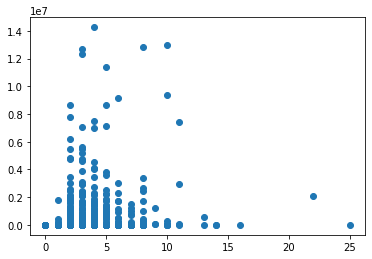

In [ ]:
plt.scatter(train_X['num_actor'],train_Y)

더미화

In [ ]:
train_X=pd.get_dummies(train_X,columns=['genre','screening_rat'])

In [ ]:
test_X=pd.get_dummies(test_X,columns=['genre','screening_rat'])

In [ ]:
train_X.head(50)

,dir_prev_bfnum,dir_prev_num,director,num_actor,num_staff,time,year,month,day,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,NaN,0,조병옥,2,91,96,2012,11,22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1.161602e+06,2,우민호,3,387,130,2015,11,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2.207752e+05,4,장철수,4,343,123,2013,6,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,2.389400e+04,2,구자홍,6,20,101,2012,7,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1.000000e+00,1,신근호,2,251,108,2010,11,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
5,8.379690e+05,2,육상효,4,262,113,2012,10,25,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
6,NaN,0,이창재,5,32,104,2013,5,23,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
7,7.395220e+05,3,임상윤,2,342,96,2012,10,11,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
8,NaN,0,정성복,5,3,129,2014,9,18,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
9,NaN,0,변성현,3,138,94,2012,3,15,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


dir_prev_bfnum NA를 어떻게 처리할 것인가?

In [ ]:
train_X['dir_prev_bfnum']=train_X['dir_prev_bfnum'].fillna(0)

In [ ]:
test_X['dir_prev_bfnum']=test_X['dir_prev_bfnum'].fillna(0)

In [ ]:
train_X.head(50)

,dir_prev_bfnum,dir_prev_num,director,num_actor,num_staff,time,year,month,day,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,0.000000e+00,0,조병옥,2,91,96,2012,11,22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1.161602e+06,2,우민호,3,387,130,2015,11,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2.207752e+05,4,장철수,4,343,123,2013,6,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,2.389400e+04,2,구자홍,6,20,101,2012,7,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1.000000e+00,1,신근호,2,251,108,2010,11,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
5,8.379690e+05,2,육상효,4,262,113,2012,10,25,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
6,0.000000e+00,0,이창재,5,32,104,2013,5,23,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
7,7.395220e+05,3,임상윤,2,342,96,2012,10,11,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
8,0.000000e+00,0,정성복,5,3,129,2014,9,18,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
9,0.000000e+00,0,변성현,3,138,94,2012,3,15,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
test_X

,dir_prev_bfnum,dir_prev_num,director,num_actor,num_staff,time,year,month,day,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,3.005290e+05,2,김형준,3,304,125,2010,1,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3.427002e+05,4,이광재,3,275,113,2010,1,14,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,4.206611e+06,3,강대규,7,419,115,2010,1,28,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,6.913420e+05,2,장훈,2,408,116,2010,2,4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,3.173800e+04,1,권호영,1,380,110,2010,2,18,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2.590000e+03,1,안슬기,4,4,78,2015,11,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
239,0.000000e+00,0,이일하,2,18,86,2015,10,29,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
240,0.000000e+00,0,안용훈,4,224,107,2015,10,28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
241,5.069900e+04,1,송동윤,7,68,102,2015,10,22,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scale_train_X = train_X.copy()
scale_test_X = test_X.copy()

In [ ]:
scale_train_X['dir_prev_bfnum']=scaler.fit_transform(np.array(scale_train_X['dir_prev_bfnum']).reshape(-1,1))

In [ ]:
scale_train_X

,dir_prev_bfnum,dir_prev_num,director,num_actor,num_staff,time,year,month,day,genre_SF,genre_공포,genre_느와르,genre_다큐멘터리,genre_드라마,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,0.000000e+00,0,조병옥,2,91,96,2012,11,22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,6.594276e-02,2,우민호,3,387,130,2015,11,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1.253314e-02,4,장철수,4,343,123,2013,6,5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,1.356433e-03,2,구자홍,6,20,101,2012,7,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,5.676879e-08,1,신근호,2,251,108,2010,11,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2.175948e-04,1,심성보,7,510,111,2014,8,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
596,2.816078e-02,1,윤종찬,6,286,127,2013,3,14,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
597,0.000000e+00,0,김대현,4,123,99,2010,9,30,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
598,0.000000e+00,0,백운학,4,431,102,2015,5,14,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
scale_test_X['dir_prev_bfnum']=scaler.fit_transform(np.array(scale_test_X['dir_prev_bfnum']).reshape(-1,1))

In [ ]:
del train_X['director']
del scale_train_X['director']
del test_X['director']
del scale_test_X['director']

----

## 모델과 평가

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import make_scorer

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

In [ ]:
def rdf(trainx,trainy,testx,estimator,alpha=0):
    max_depth_list = []

    model = RandomForestRegressor(n_estimators=estimator,
                             n_jobs=-1,
                             random_state=0)
    model.fit(trainx,trainy)
    predictions = model.predict(testx)
    scores = cross_val_score(model, trainx,trainy,cv=k_fold)
    print("**estimator = {}**".format(estimator))
    print(scores)
    print("mean_score : {:.5f}\n".format(scores.mean()))
    return predictions

In [ ]:
for i in [50,75,100,125,150]:
    xy=rdf(train_X,train_Y,test_X,i)

**estimator = 50**
[ 0.25103742  0.45476757  0.42671804  0.04232391  0.19665701  0.21275514
  0.46435481  0.29794035  0.05377771 -1.17677817]
mean_score : 0.12236

**estimator = 75**
[ 0.29070817  0.46696834  0.41610929  0.06663849  0.25967203  0.2231722
  0.47213429  0.30923582  0.12173858 -1.16754813]
mean_score : 0.14588

**estimator = 100**
[ 0.26899064  0.4865222   0.46736704  0.08549657  0.25362677  0.20864942
  0.51097821  0.31498652  0.14531491 -1.15844669]
mean_score : 0.15835

**estimator = 125**
[ 0.25347405  0.44727531  0.47609738  0.08742861  0.27882296  0.20130824
  0.48910097  0.31482701  0.16967054 -1.08197299]
mean_score : 0.16360

**estimator = 150**
[ 0.25868026  0.45225044  0.46502353  0.11174694  0.27328242  0.18441985
  0.47361239  0.31117983  0.17661924 -0.99909588]
mean_score : 0.17077



In [ ]:
def gbm(trainx,trainy,testx,estimator,alpha=0.01):
    model = GradientBoostingRegressor(n_estimators=estimator, alpha=alpha);
    model.fit(train_X, train_Y)
    preds = model.predict(test_X)
    scores = cross_val_score(model, trainx,trainy,cv=k_fold)
    print(scores)
    print("score : {:.5f}".format(scores.mean()))
    return preds

In [ ]:
for i in [1000,2000,3000,4000]:
    for j in [0.00001,0.01,0.1,1,10]:
        gbm()

In [ ]:
def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

In [ ]:
ridge = Ridge()
ridge_params = {
    'max_iter':[3000],
    'alpha':[0.01,0.1,1,5,10,100,300,1000]
}
rmsle_scorer = metrics.make_scorer(rmsle,greater_is_better=False)
grid_ridge_m = GridSearchCV(
    ridge, ridge_params, scoring = rmsle_scorer, cv=5
)

In [ ]:
y_train_log = np.log1p(train_Y)
grid_ridge_m.fit(train_X,y_train_log)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 5, 10, 100, 300, 1000],
                         'max_iter': [3000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

In [ ]:

preds = grid_ridge_m.predict(train_X)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(y_train_log),np.exp(preds), False))

{'alpha': 5, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  1.960419722752926


In [ ]:
np.exp(preds)

array([4.76267830e+03, 1.20122690e+06, 1.69758936e+06, 2.07865970e+04,
       2.78446958e+05, 3.56008626e+05, 8.93391388e+03, 1.63159998e+05,
       1.80385699e+04, 8.74239082e+03, 7.20986706e+02, 6.97164703e+03,
       5.68194491e+03, 8.02375078e+03, 1.23215188e+04, 4.08710758e+02,
       1.30154749e+07, 4.50101784e+03, 1.38875185e+05, 6.12755694e+03,
       1.37084060e+06, 6.98590787e+03, 6.38690840e+03, 4.02166787e+04,
       6.29552962e+03, 1.46024908e+04, 1.22439556e+04, 7.20986706e+02,
       4.21985278e+04, 7.89217082e+02, 3.00448120e+05, 4.08148845e+03,
       1.24689655e+04, 2.89943448e+03, 5.94993326e+05, 2.89611976e+03,
       2.32986317e+02, 1.05716760e+04, 3.22589110e+03, 4.50242625e+05,
       8.94288985e+03, 6.81472507e+03, 1.06449416e+03, 2.36037748e+03,
       1.57250942e+06, 1.56920100e+03, 1.82558046e+04, 1.21695093e+05,
       8.61505929e+06, 1.87663436e+04, 3.40930992e+04, 2.82425439e+05,
       3.82735232e+03, 7.95263303e+03, 1.54696038e+03, 1.83188717e+05,
      

In [ ]:
preds = np.exp(grid_ridge_m.predict(test_X))
print(preds)

[5.66108807e+05 3.75856082e+05 8.21732103e+05 1.82452448e+06
 1.65842105e+06 1.16581140e+04 6.77910245e+03 4.29551600e+03
 6.27954412e+03 2.01100485e+05 1.47878748e+05 3.71414079e+05
 1.22692148e+05 3.60690876e+03 1.31471746e+05 6.28376227e+06
 6.04744589e+03 3.50528799e+05 2.99233492e+04 1.79963252e+04
 1.20825859e+03 2.19134636e+04 2.85950194e+05 4.14598030e+03
 2.49379706e+03 1.07213349e+06 1.60495668e+03 2.24765399e+05
 1.12366287e+04 2.22445779e+04 1.85694092e+05 3.98616117e+03
 9.67274760e+03 1.67521295e+06 5.46134170e+03 3.14907036e+03
 5.00012861e+03 3.59751288e+03 3.75063388e+03 5.10205953e+02
 1.60696970e+04 1.18745976e+04 9.07174812e+03 3.49013609e+04
 3.40073323e+04 3.69191995e+05 2.88396612e+03 1.97912589e+04
 1.06946975e+04 3.81225862e+03 4.00199567e+03 1.26433966e+05
 1.26383302e+04 2.15347899e+05 1.05139692e+05 2.70447804e+04
 1.89062845e+04 2.76133837e+05 2.72725792e+06 3.30984930e+05
 2.91650628e+05 1.35961716e+06 4.06390553e+04 3.73973923e+03
 1.04584919e+05 1.442150

In [ ]:
raw_submission['box_off_num']=preds
raw_submission.to_csv("/content/drive/My Drive/Dacon/1_movies/ridge_submission.csv", index=False)

## 모델선택

In [ ]:
def select_model(what, estimate):
    if what=='rdf':
        result=rdf(train_X,train_Y,test_X,estimate)[0]
    elif what=='gb':
        result=gb(train_X,train_Y,test_X,estimate)[0]
    
    raw_submission['box_off_num']=result
    raw_submission.to_csv("/content/drive/My Drive/Dacon/1_movies/{}{}_submission.csv".format(str(what),estimate), index=False)

In [ ]:
select_model(what='rdf',estimate=150)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

gbm.fit(train_X, train_Y)

preds = gbm.predict(test_X)

In [ ]:
raw_submission['box_off_num']=abs(preds)

In [ ]:
raw_submission.to_csv("/content/drive/My Drive/Dacon/1_movies/gb_submission.csv", index=False)

In [ ]:
raw_submission

,title,box_off_num
0,용서는 없다,2.156732e+06
1,아빠가 여자를 좋아해,1.967043e+06
2,하모니,8.444483e+05
3,의형제,2.138930e+06
4,평행 이론,1.233660e+06
...,...,...
238,해에게서 소년에게,3.104783e+04
239,울보 권투부,1.443132e+05
240,어떤살인,9.010639e+04
241,말하지 못한 비밀,1.024468e+04
